# Helen district heat generation dataset 2015-2020

In this notebook, we read in the Helen DH dataset and fix their timestamps.

First, we request content from the server (link as of 2021-04-09) and inspect the data.

In [1]:
import requests
import pandas as pd

from io import StringIO

HELEN_DATA_URL = 'https://www.helen.fi/globalassets/helen-oy/vastuullisuus/hki_dh_2015_2020_a.csv'

content = requests.get(HELEN_DATA_URL).text
content[0:100]

'date_time;dh_MWh\r\n1.1.2015 1:00;936\r\n1.1.2015 2:00;924,2\r\n1.1.2015 3:00;926,3\r\n1.1.2015 4:00;942,1\r\n'

## Fixing timestamps

It seems that there are two columns, first including a naive timestamp and second the generation in MWh per hour. Let's read the data into a Pandas dataframe and then see to the timestamps

In [2]:
df = pd.read_csv(StringIO(content), sep=';', decimal=',', parse_dates=['date_time'], dayfirst=True)\
    .set_index('date_time')
df

,dh_MWh
date_time,
2015-01-01 01:00:00,936.000
2015-01-01 02:00:00,924.200
2015-01-01 03:00:00,926.300
2015-01-01 04:00:00,942.100
2015-01-01 05:00:00,957.100
...,...
2020-12-31 19:00:00,1191.663
2020-12-31 20:00:00,1155.601
2020-12-31 21:00:00,1149.378


Now, with naive timestamps there is most likely confusion with the daytime changes. Let's two locations we know it happening, on 29th March 2015 03:00 and on 25th October 2020 at 4:00.

In [3]:
df.loc[((df.index >='2015-03-29 00:00') & (df.index < '2015-03-29 06:00'))
        | ((df.index >= '2020-10-25 00:00') & (df.index < '2020-10-25 06:00'))]

,dh_MWh
date_time,
2015-03-29 00:00:00,958.673
2015-03-29 01:00:00,930.965
2015-03-29 02:00:00,919.913
2015-03-29 04:00:00,913.885
2015-03-29 05:00:00,908.093
2020-10-25 00:00:00,871.322
2020-10-25 01:00:00,860.284
2020-10-25 02:00:00,848.808
2020-10-25 03:00:00,851.583


So there it is, time hops two hours between 2015-03-29 02:00:00 and 2015-03-29 04:00:00,
and two similar timestamps exist at 2020-10-25 03:00:00. We will fix that next with `tz_localize`,
[see documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.tz_localize.html).
Ambiguous parameter 'infer' attempts to sort out autumn daylight saving time transition based on appearance order.

In [4]:
df.index = df.index.tz_localize(tz='Europe/Helsinki', ambiguous='infer')

In [5]:
df.loc[((df.index >='2015-03-29 00:00') & (df.index < '2015-03-29 06:00'))
        | ((df.index >= '2020-10-25 00:00') & (df.index < '2020-10-25 06:00'))]

,dh_MWh
date_time,
2015-03-29 00:00:00+02:00,958.673
2015-03-29 01:00:00+02:00,930.965
2015-03-29 02:00:00+02:00,919.913
2015-03-29 04:00:00+03:00,913.885
2015-03-29 05:00:00+03:00,908.093
2020-10-25 00:00:00+03:00,871.322
2020-10-25 01:00:00+03:00,860.284
2020-10-25 02:00:00+03:00,848.808
2020-10-25 03:00:00+03:00,851.583


It seems correct now! Let's check.

In [6]:
len(df.index.unique()) == len(df)

True

Finally, we will check that there is one hour difference between all rows

In [7]:
index_steps = df.index.to_frame().diff()
index_steps.loc[index_steps['date_time'] != pd.Timedelta('1 hours')]

,date_time
date_time,
2015-01-01 01:00:00+02:00,NaT


# Basic plotting

Let's have a look at the data, plotted fully, and then a subplot

<AxesSubplot:xlabel='date_time'>

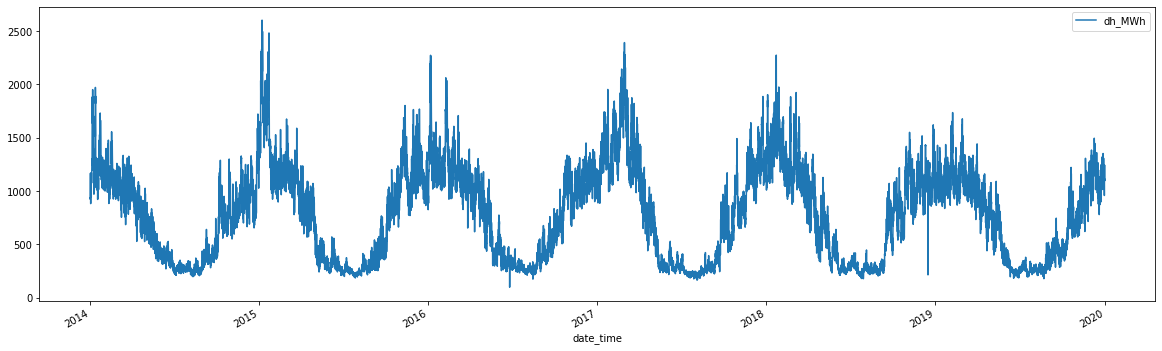

In [8]:
df.plot(figsize=(20,6))

<AxesSubplot:xlabel='date_time'>

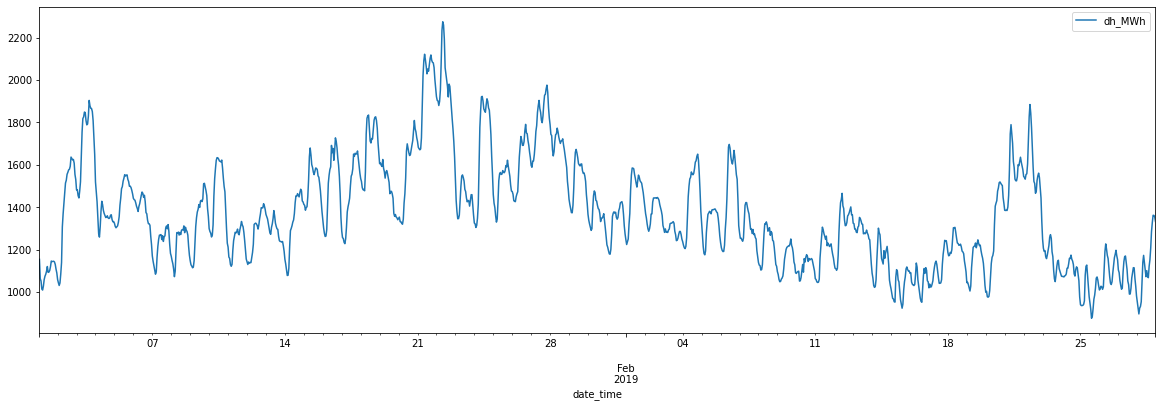

In [9]:
df.loc[(df.index > '2019-01-01') & (df.index < '2019-03-01')].plot(figsize=(20,6))

## Next steps

The data seems to be in order. Next one would like to plot correlations with the temperature, build models _et cetera_. This will be left for another time.